# Iterative Prompt Optimization Using Llama 3.1 8B

In [1]:
import torch
import random
import ollama
from langchain.llms import Ollama
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate
from diffusers import StableDiffusionPipeline
from transformers import CLIPModel, CLIPProcessor
import pandas as pd
# from diffusers import AutoPipelineForText2Image
from transformers import PreTrainedTokenizerFast
from diffusers import DiffusionPipeline
from diffusers import StableDiffusionXLPipeline


c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the LLM using LangChain and Ollama
llm = Ollama(model="llama3.1")

C:\Users\zeina\AppData\Local\Temp\ipykernel_35552\3033838252.py:2: LangChainDeprecationWarning: The class `Ollama` was deprecated in LangChain 0.3.1 and will be removed in 1.0.0. An updated version of the class exists in the :class:`~langchain-ollama package and should be used instead. To use it run `pip install -U :class:`~langchain-ollama` and import as `from :class:`~langchain_ollama import OllamaLLM``.
  llm = Ollama(model="llama3.1")


In [3]:
def verify_ollama():
    response = ollama.chat(model="llama3.1", messages=[{"role": "user", "content": "Hello, how are you?"}])
    print("LLM Response:", response["message"])  # Corrected response extraction

verify_ollama()

LLM Response: role='assistant' content="I'm just a computer program, so I don't have feelings in the same way humans do. But I'm functioning properly and ready to help with any questions or tasks you may have! How about you? How's your day going so far?" images=None tool_calls=None


In [ ]:
llm = Ollama(model="llama3.1")
#more sophisticated text-to-image sd model
pipe = StableDiffusionXLPipeline.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16").to("cuda")
total_params = sum(p.numel() * p.element_size() for p in pipe.unet.parameters())
total_params += sum(p.numel() * p.element_size() for p in pipe.text_encoder.parameters())
total_params += sum(p.numel() * p.element_size() for p in pipe.vae.parameters())
print(f"Model memory size (in RAM): {total_params / 1e9:.2f} GB")



Loading pipeline components...: 100%|██████████| 7/7 [00:00<00:00,  7.28it/s]


Model memory size (in RAM): 5.55 GB


## Clip Scorer

In [4]:
# Load model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
import torch
from PIL import Image
import spacy  # For noun phrase extraction

# Load NLP model for extracting noun phrases
nlp = spacy.load("en_core_web_sm")

def extract_noun_phrases(text):
    """Extracts noun phrases from a given text using SpaCy."""
    doc = nlp(text)
    return [chunk.text for chunk in doc.noun_chunks]

def compute_decomposed_clip_score(image_path, text_prompt):
    """Computes CLIP Score by averaging similarity scores for each noun phrase in the prompt."""
    # Ensure `image_path` is a string
    if isinstance(image_path, list):
        image_path = image_path[0]  # Extract the actual path if it's a list

    # Load image correctly
    image = Image.open(image_path)

    # Extract meaningful chunks (noun phrases)
    noun_phrases = extract_noun_phrases(text_prompt)
    
    if not noun_phrases:
        noun_phrases = [text_prompt]  # If no noun phrases are detected, use full prompt
    
    scores = []
    
    for phrase in noun_phrases:
        # Tokenize text (ensure it's within CLIP's 77-token limit)
        inputs = processor(images=image, text=phrase, return_tensors="pt")

        # Move inputs and model to the same device
        inputs = {key: value.to("cuda") for key, value in inputs.items()}
        model.to("cuda")

        with torch.no_grad():
            outputs = model(**inputs)
            image_features = outputs.image_embeds
            text_features = outputs.text_embeds

        # Normalize features
        image_features /= image_features.norm(dim=-1, keepdim=True)
        text_features /= text_features.norm(dim=-1, keepdim=True)

        # Compute similarity (CLIP score)
        similarity = (image_features @ text_features.T).item()
        scores.append(similarity)

    # Compute final decomposed CLIP score (average of all phrase scores)
    final_score = sum(scores) / len(scores)
    return final_score




# DSG Scorer

In [6]:
import ollama
from pprint import pprint

def generate_dsg_with_llama(prompt):
    # === 1. Tuple Generation (Fixed) ===
    tuple_prompt = f"""
    Extract ALL elements from this prompt. Follow STRICT rules:
    
    RULES:
    1. Format: "id | type - subtype (arguments)"
    2. Types: entity, attribute, relation
    3. Subtypes:
       - entity: vehicle, object, person
       - attribute: color, state, condition
       - relation: spatial
    4. MUST include ALL mentioned elements
    5. NO additional text or explanations

    EXAMPLE INPUT: "A red apple on a wooden table"
    EXAMPLE OUTPUT:
    1 | entity - object (apple)
    2 | attribute - color (apple, red)
    3 | entity - object (table)
    4 | attribute - material (table, wooden)
    5 | relation - spatial (apple, table, on)

    CURRENT PROMPT: "{prompt}"
    OUTPUT:
    """
    tuple_response = ollama.generate(
        model="llama3.1",
        prompt=tuple_prompt,
        options={"temperature": 0.1, "max_tokens": 500}
    )
    tuples = [line.strip() for line in tuple_response["response"].strip().split("\n") 
              if "|" in line and line.strip()]
    tuples = "\n".join(tuples)

    # === 2. Yes/No Question Generation (Fixed) ===
    question_prompt = f"""
    Create YES/NO questions about this scene. Follow STRICT rules:
    
    RULES:
    1. Only ask about EXPLICITLY mentioned elements
    2. Start every question with "Is" or "Are"
    3. Format: "id | question"
    4. MUST cover all main objects/attributes/relations
    5. NO hypotheticals (e.g., riders, owners)

    BAD EXAMPLE: "Does the motorcycle have a horn?" 
    (not mentioned)
    BAD EXAMPLE: "Where is the motorcycle?"
    (not a yes/no question)
    
    GOOD EXAMPLE: "Is the motorcycle blue?"

    EXAMPLE OUTPUT FOR "A red apple on a table":
    1 | Is there an apple?
    2 | Is the apple red?
    3 | Is there a table?
    4 | Is the apple on the table?

    CURRENT PROMPT: "{prompt}"
    QUESTIONS:
    """
    question_response = ollama.generate(
        model="llama3.1",
        prompt=question_prompt,
        options={"temperature": 0.1, "max_tokens": 500}
    )
    questions = [line.strip() for line in question_response["response"].strip().split("\n") 
                if "|" in line and line.strip()]
    questions = "\n".join(questions)

    # === 3. Dependency Generation (Fixed) ===
    dependency_prompt = f"""
    Generate dependencies for these tuples. Follow STRICT rules:
    
    RULES:
    1. Attributes depend on their entity
    2. Relations depend on their subject AND object
    3. Format: "id | parent_ids" (comma separated or empty)
    4. Entities have no dependencies
    5. NO explanations

    EXAMPLE INPUT:
    1 | entity - object (apple)
    2 | attribute - color (apple, red)
    3 | relation - spatial (apple, table, on)

    EXAMPLE OUTPUT:
    1 |
    2 | 1
    3 | 1

    CURRENT TUPLES:
    {tuples}
    
    DEPENDENCIES:
    """
    dependency_response = ollama.generate(
        model="llama3.1",
        prompt=dependency_prompt,
        options={"temperature": 0.1, "max_tokens": 500}
    )
    dependencies = [line.strip() for line in dependency_response["response"].strip().split("\n") 
                  if "|" in line and line.strip()]
    dependencies = "\n".join(dependencies)

    return {
        "tuples": tuples,
        "questions": questions,
        "dependencies": dependencies
    }


In [7]:
from PIL import Image
from transformers import BlipProcessor, BlipForQuestionAnswering

def evaluate_dsg_independent(dsg_output, generated_image):
    """Evaluate DSG questions without dependency checks using BLIP VQA"""
    
    # Initialize BLIP model
    processor = BlipProcessor.from_pretrained("Salesforce/blip-vqa-base")
    model = BlipForQuestionAnswering.from_pretrained("Salesforce/blip-vqa-base")
    
    # 1) Parse questions
    qid2question = {}
    for line in dsg_output['questions'].split('\n'):
        if '|' in line:
            qid, question = line.split('|', 1)
            qid2question[int(qid.strip())] = question.strip()
    
    # 2) Process image (handles both paths and PIL Images)
    if isinstance(generated_image, str):
        raw_image = Image.open(generated_image).convert('RGB')
    else:
        raw_image = generated_image.convert('RGB') if hasattr(generated_image, 'convert') else generated_image
    
    # 3) Get answers and scores
    qid2answer = {}
    qid2scores = {}
    
    for qid, question in qid2question.items():
        # BLIP-specific processing
        inputs = processor(raw_image, question, return_tensors="pt")
        out = model.generate(**inputs)
        answer = processor.decode(out[0], skip_special_tokens=True)
        
        qid2answer[qid] = answer
        # Handle BLIP's verbose answers (check for "yes", "yeah", etc.)
        qid2scores[qid] = 1 if any(yes_word in answer.lower() for yes_word in ['yes', 'yeah', 'true']) else 0
    
    # 4) Calculate average score
    average_score = sum(qid2scores.values()) / len(qid2scores)
    
    # 5) Print results
    print("Independent Question Evaluation (BLIP):")
    for qid in sorted(qid2question.keys()):
        print(f"Q{qid}: {qid2question[qid]}")
        print(f"→ Answer: {qid2answer[qid]}")
        print(f"→ Score: {qid2scores[qid]}")
        print()
    
    print(f"Average Score: {average_score:.2f}")
    
    return average_score

In [8]:
def DSG_Scorer(generated_image,prompt):
    """
    Evaluate the generated image using the DSG output.
    """
    dsg_output = generate_dsg_with_llama(prompt)
    return evaluate_dsg_independent(dsg_output, generated_image)

## Initial Prototype

In [8]:
# Step 1: Generate Alternative Prompts using LLM and LangChain
def generate_prompt_variations(prompt, num_variations=1):
    print("Generating prompt variations\n")
    prompt_template = PromptTemplate(
        template="""You are an expert prompt optimizer for text-to-image models. Text-to-image models take a text prompt as
        input and generate images depicting the prompt as output. You translate prompts written by humans into
        better prompts for the text-to-image models. Your answers should be concise and effective.
        Your task is to optimize this initial prompt written by a human: {prompt}
        Output: a better prompt that can generate a more accurate and visually appealing image. Provide only the prompt as output.""",
        input_variables=["prompt"]
    )
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)
    
    variations = []
    for _ in range(num_variations):
        response = llm_chain.run(prompt)
        variations.append(response.strip())
    return variations

# Step 2: Generate Images
def generate_images(prompts):
    print("Generating images\n")
    images = []
    for prompt in prompts:
        image = sd_pipeline(prompt).images[0]
        image_path = f"generated_image_{random.randint(1000, 9999)}.png"
        image.save(image_path)
        images.append((image_path, prompt))
    return images

# Step 3: Evaluate Consistency
def evaluate_images(images):
    print("Evaluating images\n")
    scores = []
    for image_path, prompt in images:
        clip_score = compute_decomposed_clip_score(image_path, prompt)
        #vqa_score = vqa_metric([image_path], [prompt])
        total_score = clip_score #+ vqa_score
        scores.append((image_path, prompt, total_score))
    return sorted(scores, key=lambda x: x[2], reverse=True)

# Step 4: Iterative Refinement
def iterative_prompt_optimization(initial_prompt, max_iterations=3, threshold=0.95):
    global df_log  # Use the global DataFrame to store results
    current_prompt = initial_prompt
    best_score = 0
    best_prompt = current_prompt
    best_image_path = None

    for iteration in range(max_iterations):
        print(f"\n🔄 Iteration {iteration + 1}...")
        prompt_variations = generate_prompt_variations(current_prompt)
        generated_images = generate_images(prompt_variations)
        ranked_images = evaluate_images(generated_images)

        best_image_path, best_prompt, best_score = ranked_images[0]

        # Log results in the DataFrame

        newRow = pd.DataFrame({"Iteration": iteration + 1, "Prompt": best_prompt, "Image Path": best_image_path, "CLIP Score": best_score}, index=[0])
        df_log = pd.concat([df_log, newRow]).reset_index(drop=True)

        print(f"✅ Best prompt (Iteration {iteration + 1}): {best_prompt} (Score: {best_score}) - Image: {best_image_path}")

        if best_score >= threshold:
            print("✅ Converged! Stopping early.")
            break

        current_prompt = best_prompt

    print("Generating final optimized image...")
    final_image = sd_pipeline(best_prompt).images[0]
    final_image.save("final_optimized_image.png")
    #add final_optimized_image.png to the dataframe
    newRow = pd.DataFrame({"Iteration": iteration + 1, "Prompt": best_prompt, "Image Path": "final_optimized_image.png", "CLIP Score": compute_decomposed_clip_score('final_optimized_image.png',best_prompt)}, index=[0])
    df_log = pd.concat([df_log, newRow]).reset_index(drop=True)
    print("✅ Final optimized image saved!")


In [9]:
# Example usage
df_log = pd.DataFrame(columns=["Iteration", "Prompt", "Image Path", "CLIP Score"])
original_prompt = """Setting: The scene takes place in a village, with a warm atmosphere. It's morning, and the sun is not yet too hot. The environment is peaceful.
Characters: Little Red Riding Hood (a young girl), her mother.
Actions: Little Red Riding Hood's mother asks her to take some cakes to her sick grandmother who lives in another village. She gives her specific instructions about taking the path through the forest and warns her not to talk to strangers.
Interactions: The interaction between Little Red Riding Hood and her mother is one of concern and responsibility. The mother wants to ensure her daughter's safety while also helping their ailing grandmother."""
iterative_prompt_optimization(original_prompt)


🔄 Iteration 1...
Generating prompt variations



C:\Users\zeina\AppData\Local\Temp\ipykernel_45760\1486877794.py:12: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  llm_chain = LLMChain(llm=llm, prompt=prompt_template)
C:\Users\zeina\AppData\Local\Temp\ipykernel_45760\1486877794.py:16: LangChainDeprecationWarning: The method `Chain.run` was deprecated in langchain 0.1.0 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = llm_chain.run(prompt)
Token indices sequence length is longer than the specified maximum sequence length for this model (78 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['."']


Generating images



100%|██████████| 50/50 [05:11<00:00,  6.24s/it]


Evaluating images



C:\Users\zeina\AppData\Local\Temp\ipykernel_45760\1486877794.py:61: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_log = pd.concat([df_log, newRow]).reset_index(drop=True)


✅ Best prompt (Iteration 1): "A young girl, Little Red Riding Hood, stands in front of her village home on a warm morning, wearing a hooded red cloak. Her mother hands her a basket with freshly baked cakes and instructs her to deliver them to their sick grandmother in a neighboring village, advising her to take the forest path but avoid interacting with strangers as they share a moment of concern and responsibility." (Score: 0.21997685659499394) - Image: generated_image_1558.png

🔄 Iteration 2...
Generating prompt variations

Generating images



100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


Evaluating images

✅ Best prompt (Iteration 2): "A young girl, dressed in a red hooded cloak, stands in front of her village home on a warm morning, holding a basket of freshly baked goods handed to her by her mother. Her expression conveys innocence and determination as she prepares to visit her sick grandmother in a neighboring village, following the forest path while avoiding strangers and adhering to her mother's instructions." (Score: 0.22744037128157085) - Image: generated_image_4611.png

🔄 Iteration 3...
Generating prompt variations

Generating images



100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


Evaluating images

✅ Best prompt (Iteration 3): "A young girl in a red hooded cloak stands before her cozy village home on a warm morning, holding a basket of freshly baked goods. With an innocent yet determined expression, she embarks on a journey to visit her ailing grandmother in a nearby village, following the winding forest path as instructed by her mother." (Score: 0.23568650965507215) - Image: generated_image_7809.png
Generating final optimized image...


100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


✅ Final optimized image saved!


In [10]:
df_log.head()

,Iteration,Prompt,Image Path,CLIP Score
0,1,"""A young girl, Little Red Riding Hood, stands ...",generated_image_1558.png,0.219977
1,2,"""A young girl, dressed in a red hooded cloak, ...",generated_image_4611.png,0.227440
2,3,"""A young girl in a red hooded cloak stands bef...",generated_image_7809.png,0.235687
3,3,"""A young girl in a red hooded cloak stands bef...",final_optimized_image.png,0.233045


# Prototype After Adding history and Top K (Clip Score Only)

In [20]:
import random
import pandas as pd
from langchain.prompts import PromptTemplate
from langchain.chains import LLMChain

In [21]:
# Step 1: Generate Alternative Prompts using LLM and LangChain
device = "cuda" if torch.cuda.is_available() else "cpu"
def generate_prompt_variations(prompt, history, num_variations=1):
    meta_prompt = """You are an expert prompt optimizer for text-to-image models. Text-to-image models take a text prompt as
        input and generate images depicting the prompt as output. You translate prompts written by humans into
        better prompts for the text-to-image models. Your answers should be concise and effective.
         Given this optimization history:
    {history}
    
    Your task is to optimize this initial prompt written by a human: {prompt}
    Output: a better prompt that can generate a more accurate and visually appealing image. Provide only the prompt as output.
    """
    
    # Changed input variables to include both parameters
    prompt_template = PromptTemplate(
        template=meta_prompt,
        input_variables=["history", "prompt"]  # NOW INCLUDES BOTH
    )
    
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)
    
    variations = []
    for _ in range(num_variations):
        # Pass both variables as dictionary
        response = llm_chain.run({
            "prompt": prompt,
            "history": history  # NOW INCLUDED
        })
        variations.append(response.strip())
    check_memory_usage()
    return variations




# Step 2: Generate Images
def generate_images(prompts):
    print("Generating images\n")
    images = []
    for prompt in prompts:
        image = pipe(prompt).images[0]
        image_path = f"generated_image_c_{random.randint(1000, 9999)}.png"
        image.save(image_path)
        images.append((image_path, prompt))
        check_memory_usage()
    return images

# Step 3: Evaluate Consistency (Multi-Metric: CLIP + VQA)
def evaluate_images(images):
    print("Evaluating images\n")
    scores = []
    for image_path, prompt in images:
        clip_score = compute_decomposed_clip_score(image_path, prompt)
        #vqa_score = compute_vqa_score(image_path, "What is in this image?", prompt)  # Now using VQA
        #total_score = (clip_score + vqa_score) / 2  # Weighted average
        scores.append((image_path, prompt, clip_score))
    check_memory_usage()
    return sorted(scores, key=lambda x: x[2], reverse=True)

# Step 4: Iterative Refinement with Top-k History Retention
def iterative_prompt_optimization(initial_prompt, max_iterations=5, threshold=0.95, top_k=3):
    global df_log
    
    current_prompt = initial_prompt
    history = ""
    best_score = 0
    best_prompt = current_prompt
    best_image_path = None
    
    for iteration in range(max_iterations):
        print(f"\n🔄 Iteration {iteration + 1}...")
        
        prompt_variations = generate_prompt_variations(current_prompt, history, num_variations=top_k)
        generated_images = generate_images(prompt_variations)
        ranked_images = evaluate_images(generated_images)
        
        # Retain top-k best prompts and update history
        top_k_prompts = ranked_images[:top_k]
        history = "\n".join([f"Prompt: {p}, Clip Score: {s}" for _, p, s in top_k_prompts])
        
        best_image_path, best_prompt, best_score = top_k_prompts[0]
        
        newRow = pd.DataFrame({"Iteration": iteration + 1, "Prompt": best_prompt, "Image Path": best_image_path, "Clip Score": best_score, "Score":0}, index=[0])
        df_log = pd.concat([df_log, newRow]).reset_index(drop=True)
        
        print(f"✅ Best prompt (Iteration {iteration + 1}): {best_prompt} (Score: {best_score}) - Image: {best_image_path}")
        
        if best_score >= threshold:
            print("✅ Converged! Stopping early.")
            break
        
        current_prompt = best_prompt
        check_memory_usage()
    
    print("Generating final optimized image...")
    final_image = pipe(best_prompt).images[0]
    final_image.save("final_optimized_image.png")
    final_score = compute_decomposed_clip_score('final_optimized_image.png', best_prompt)
    
    newRow = pd.DataFrame({"Iteration": iteration + 1, "Prompt": best_prompt, "Image Path": "final_optimized_image.png", "Clip Score": final_score, "Score": 0}, index=[0])
    df_log = pd.concat([df_log, newRow]).reset_index(drop=True)
    print("✅ Final optimized image saved!")


In [60]:
check_memory_usage()

Allocated VRAM: 7.67 GB
Reserved VRAM:  8.16 GB


In [59]:
clear_gpu_cache()
clear_cpu_cache()

In [ ]:
df_log = pd.DataFrame(columns=["Iteration", "Prompt", "Image Path", "CLIP Score"])
original_prompt = """Setting: The scene takes place in a village, with a warm atmosphere. It's morning, and the sun is not yet too hot. The environment is peaceful.
Characters: Little Red Riding Hood (a young girl), her mother.
Actions: Little Red Riding Hood's mother asks her to take some cakes to her sick grandmother who lives in another village. She gives her specific instructions about taking the path through the forest and warns her not to talk to strangers.
Interactions: The interaction between Little Red Riding Hood and her mother is one of concern and responsibility. The mother wants to ensure her daughter's safety while also helping their ailing grandmother."""
iterative_prompt_optimization(original_prompt)

In [ ]:
df_log.head(18)

,Iteration,Prompt,Image Path,CLIP Score


In [ ]:
check_memory_usage()

# Prototype After Adding history and Top K (Clip Score Only) Optimized

In [39]:
# Step 1: Generate Alternative Prompts using LLM and LangChain
device = "cuda" if torch.cuda.is_available() else "cpu"
def generate_prompt_variations(prompt, history, num_variations=1):
    meta_prompt = """You are an expert prompt optimizer for text-to-image models. Text-to-image models take a text prompt as
        input and generate images depicting the prompt as output. You translate prompts written by humans into
        better prompts for the text-to-image models. Your answers should be concise and effective.
         Given this optimization history:
    {history}
    
    Your task is to optimize this initial prompt written by a human: {prompt}
    Output: a better prompt that can generate a more accurate and visually appealing image. Provide only the prompt as output.
    """
    
    # Changed input variables to include both parameters
    prompt_template = PromptTemplate(
        template=meta_prompt,
        input_variables=["history", "prompt"]  # NOW INCLUDES BOTH
    )
    
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)
    
    variations = []
    for _ in range(num_variations):
        # Pass both variables as dictionary
        response = llm_chain.run({
            "prompt": prompt,
            "history": history  # NOW INCLUDED
        })
        variations.append(response.strip())
    return variations




# Step 2: Generate Images
def generate_images(prompts):
    print("Generating images\n")
    images = []
    for prompt in prompts:
        image = pipe(prompt).images[0]
        image_path = f"generated_image_COP_{random.randint(1000, 9999)}.png"
        image.save(image_path)
        images.append((image_path, prompt))
        clear_gpu_cache()
        clear_cpu_cache()  # Clear GPU cache after each image generation
    return images

# Step 3: Evaluate Consistency (Multi-Metric: CLIP + VQA)
def evaluate_images(images):
    print("Evaluating images\n")
    scores = []
    for image_path, prompt in images:
        clip_score = compute_decomposed_clip_score(image_path, prompt)
        #vqa_score = compute_vqa_score(image_path, "What is in this image?", prompt)  # Now using VQA
        #total_score = (clip_score + vqa_score) / 2  # Weighted average
        scores.append((image_path, prompt, clip_score))
        clear_gpu_cache()  # Clear GPU cache after each evaluation
        clear_cpu_cache()  
    return sorted(scores, key=lambda x: x[2], reverse=True)

# Step 4: Iterative Refinement with Top-k History Retention
def iterative_prompt_optimization(initial_prompt, max_iterations=3, threshold=0.95, top_k=3):
    global df_log2
    
    current_prompt = initial_prompt
    history = ""
    best_score = 0
    best_prompt = current_prompt
    best_image_path = None
    
    for iteration in range(max_iterations):
        print(f"\n🔄 Iteration {iteration + 1}...")
        
        prompt_variations = generate_prompt_variations(current_prompt, history, num_variations=top_k)
        generated_images = generate_images(prompt_variations)
        ranked_images = evaluate_images(generated_images)
        
        # Retain top-k best prompts and update history
        top_k_prompts = ranked_images[:top_k]
        history = "\n".join([f"Prompt: {p}, Clip Score: {s}" for _, p, s in top_k_prompts])
        
        best_image_path, best_prompt, best_score = top_k_prompts[0]
        
        newRow = pd.DataFrame({"Iteration": iteration + 1, "Prompt": best_prompt, "Image Path": best_image_path, "Clip Score": best_score, "Score":0}, index=[0])
        df_log2 = pd.concat([df_log2, newRow]).reset_index(drop=True)
        
        print(f"✅ Best prompt (Iteration {iteration + 1}): {best_prompt} (Score: {best_score}) - Image: {best_image_path}")
        
        if best_score >= threshold:
            print("✅ Converged! Stopping early.")
            break
        
        current_prompt = best_prompt
        check_memory_usage()
    
    print("Generating final optimized image...")
    final_image = pipe(best_prompt).images[0]
    final_image.save("final_optimized_image_COP.png")
    final_score = compute_decomposed_clip_score('final_optimized_image_COP.png', best_prompt)
    
    newRow = pd.DataFrame({"Iteration": iteration + 1, "Prompt": best_prompt, "Image Path": "final_optimized_image.png", "Clip Score": final_score, "Score":0}, index=[0])
    df_log2 = pd.concat([df_log2, newRow]).reset_index(drop=True)
    print("✅ Final optimized image saved!")


In [45]:
check_memory_usage()

Allocated VRAM: 7.67 GB
Reserved VRAM:  8.28 GB


In [46]:
df_log2 = pd.DataFrame(columns=["Iteration", "Prompt", "Image Path", "CLIP Score", "Score"])
original_prompt = """Setting: The scene takes place in a village, with a warm atmosphere. It's morning, and the sun is not yet too hot. The environment is peaceful.
Characters: Little Red Riding Hood (a young girl), her mother.
Actions: Little Red Riding Hood's mother asks her to take some cakes to her sick grandmother who lives in another village. She gives her specific instructions about taking the path through the forest and warns her not to talk to strangers.
Interactions: The interaction between Little Red Riding Hood and her mother is one of concern and responsibility. The mother wants to ensure her daughter's safety while also helping their ailing grandmother."""
iterative_prompt_optimization(original_prompt)


🔄 Iteration 1...
Generating images



100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Evaluating images

✅ Best prompt (Iteration 1): A young girl, Little Red Riding Hood, wearing a red cloak, walks through a serene forest path with a basket of freshly baked cakes, accompanied by her mother. They are heading to visit her sick grandmother in a nearby village. The scene is set in a warm and peaceful morning atmosphere, with dappled sunlight filtering through the trees. (Score: 0.24211627032075608) - Image: generated_image_COP_3913.png
Allocated VRAM: 7.67 GB
Reserved VRAM:  8.12 GB

🔄 Iteration 2...
Generating images



100%|██████████| 50/50 [00:21<00:00,  2.34it/s]


Evaluating images

✅ Best prompt (Iteration 2): "A young girl in a red cloak walks hand-in-hand with her mother through a serene forest path towards their grandmother's village house, surrounded by dappled sunlight and gentle foliage." (Score: 0.23986753076314926) - Image: generated_image_COP_7959.png
Allocated VRAM: 7.67 GB
Reserved VRAM:  8.08 GB

🔄 Iteration 3...
Generating images



100%|██████████| 50/50 [00:16<00:00,  3.12it/s]


Evaluating images

✅ Best prompt (Iteration 3): "Cozy morning scene of Little Red Riding Hood walking hand-in-hand with her mother down a serene forest path, lined with tall trees and vibrant flowers, their bright red cloak and baskets of freshly baked treats illuminated by warm dappled sunlight on their way to visit their grandmother in a nearby village surrounded by gentle foliage and soft mist." (Score: 0.24023208860307932) - Image: generated_image_COP_6874.png
Allocated VRAM: 7.67 GB
Reserved VRAM:  8.07 GB
Generating final optimized image...


100%|██████████| 50/50 [00:19<00:00,  2.52it/s]


✅ Final optimized image saved!


In [47]:
df_log2.head(18)

,Iteration,Prompt,Image Path,CLIP Score,Score,Clip Score
0,1,"A young girl, Little Red Riding Hood, wearing ...",generated_image_COP_3913.png,NaN,0,0.242116
1,2,"""A young girl in a red cloak walks hand-in-han...",generated_image_COP_7959.png,NaN,0,0.239868
2,3,"""Cozy morning scene of Little Red Riding Hood ...",generated_image_COP_6874.png,NaN,0,0.240232
3,3,"""Cozy morning scene of Little Red Riding Hood ...",final_optimized_image.png,NaN,0,0.231453


# Prototype after adding DSG Score

In [ ]:
# Step 1: Generate Alternative Prompts using LLM and LangChain
device = "cuda" if torch.cuda.is_available() else "cpu"
def generate_prompt_variations(prompt, history, num_variations=1):

    prompt_template = """
 You are an expert prompt optimizer for text-to-image models. Text-to-image models take a text prompt as
 input and generate images depicting the prompt as output. You translate prompts written by humans into
 better prompts for the text-to-image models. Your answers should be concise and effective.
 Your task is to optimize this initial prompt written by a human: "{user_prompt}". Below are some
 previous prompts with a decomposition of their visual elements. Each element is paired with a score
 indicating its presence in the generated image. The prompts are arranged in ascending order based on
 their scores, which range from 0 to 100. Higher scores indicate higher likelihood of presence."""

    meta_prompt = """You are an expert prompt optimizer for text-to-image models. Text-to-image models take a text prompt as
        input and generate images depicting the prompt as output. You translate prompts written by humans into
        better prompts for the text-to-image models. Your answers should be concise and effective.
         Given this optimization history:
    {history}
    
    Your task is to optimize this initial prompt written by a human: {prompt}
    Output: a better prompt that can generate a more accurate and visually appealing image. Provide only the prompt as output.
    - YOU MUST NOT CHANGE THE SEMANTICS OF THE PROMPT, ONLY IMPROVE THE LANGUAGE AND CLARITY.
    - DO NOT ADD ANY ELEMENTS THAT ARE NOT PRESENT OR IMPLIED IN THE ORIGINAL PROMPT.
    """
    
    # Changed input variables to include both parameters
    prompt_template = PromptTemplate(
        template=meta_prompt,
        input_variables=["history", "prompt"]  # NOW INCLUDES BOTH
    )
    
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)
    
    variations = []
    for _ in range(num_variations):
        # Pass both variables as dictionary
        response = llm_chain.run({
            "prompt": prompt,
            "history": history  # NOW INCLUDED
        })
        variations.append(response.strip())
    return variations




# Step 2: Generate Images
def generate_images(prompts):
    print("Generating images\n")
    images = []
    for prompt in prompts:
        image = pipe(prompt).images[0]
        image_path = f"generated_image_DSG_{random.randint(1000, 9999)}.png"
        image.save(image_path)
        images.append((image_path, prompt))
        clear_gpu_cache()  # Clear GPU cache after each image generation
        clear_cpu_cache()  # Clear CPU cache after each image generation
    return images

# Step 3: Evaluate Consistency (Multi-Metric: CLIP + VQA)
def evaluate_images(images):
    print("Evaluating images\n")
    scores = []
    for image_path, prompt in images:
        clip_score = compute_decomposed_clip_score(image_path, prompt)
        dsg_score = DSG_Scorer(image_path, prompt)  # Your new function
        avg_score = ((0.2 * clip_score) + (0.8 * dsg_score))
        scores.append((image_path, prompt, clip_score, dsg_score, avg_score))
        clear_gpu_cache()
        clear_cpu_cache()  
    return sorted(scores, key=lambda x: x[4], reverse=True)  # sort by avg_score


# Step 4: Iterative Refinement with Top-k History Retention
def iterative_prompt_optimization(initial_prompt, max_iterations=3, threshold=0.95, top_k=3):
    global df_log3
    
    current_prompt = initial_prompt
    history = ""
    best_avg_score = 0
    best_prompt = current_prompt
    best_image_path = None
    
    for iteration in range(max_iterations):
        print(f"\n🔄 Iteration {iteration + 1}...")
        
        prompt_variations = generate_prompt_variations(current_prompt, history, num_variations=top_k)
        generated_images = generate_images(prompt_variations)
        ranked_images = evaluate_images(generated_images)
        
        # Update history with top-k best prompts including both scores
        top_k_prompts = ranked_images[:top_k]
        history = "\n".join([
            f"Prompt: {p}, Clip Score: {cs:.4f}, DSG Score: {ds:.4f}, Avg Score: {avg:.4f}"
            for _, p, cs, ds, avg in top_k_prompts
        ])
        
        best_image_path, best_prompt, best_clip, best_dsg, best_avg_score = top_k_prompts[0]
        
        newRow = pd.DataFrame({
            "Iteration": [iteration + 1],
            "Prompt": [best_prompt],
            "Image Path": [best_image_path],
            "Clip Score": [best_clip],
            "DSG Score": [best_dsg],
            "Avg Score": [best_avg_score]
        })
        df_log3 = pd.concat([df_log3, newRow], ignore_index=True)
        
        print(f"✅ Best prompt (Iteration {iteration + 1}): {best_prompt} (Avg Score: {best_avg_score:.4f}) - Image: {best_image_path}")
        
        if best_avg_score >= threshold:
            print("✅ Converged! Stopping early.")
            break
        
        current_prompt = best_prompt
        check_memory_usage()
    
    print("Generating final optimized image...")
    final_image = pipe(best_prompt).images[0]
    final_image.save("final_optimized_image_dsg_.png")
    final_clip = compute_decomposed_clip_score('final_optimized_image_dsg_.png', best_prompt)
    final_dsg = DSG_Scorer('final_optimized_image_dsg_.png', best_prompt)
    final_avg = ((0.2 * final_clip) + (0.8 * final_dsg))
    
    newRow = pd.DataFrame({
        "Iteration": [iteration + 2],
        "Prompt": [best_prompt],
        "Image Path": ["final_optimized_image_dsg_.png"],
        "Clip Score": [final_clip],
        "DSG Score": [final_dsg],
        "Avg Score": [final_avg]
    })
    df_log3 = pd.concat([df_log3, newRow], ignore_index=True)
    print("✅ Final optimized image saved!")


    


In [20]:
# Step 1: Generate Alternative Prompts using LLM and LangChain
device = "cuda" if torch.cuda.is_available() else "cpu"
def generate_prompt_variations(prompt, history, num_variations=1):

    prompt_template = """
 You are an expert prompt optimizer for text-to-image models. Text-to-image models take a text prompt as
 input and generate images depicting the prompt as output. You translate prompts written by humans into
 better prompts for the text-to-image models. Your answers should be concise and effective.
 Your task is to optimize this initial prompt written by a human: "{prompt}". Below are some
 previous prompts with a decomposition of their visual elements. Each element is paired with a score
 indicating its presence in the generated image. The prompts are arranged in ascending order based on
 their scores, which range from 0 to 100. Higher scores indicate higher likelihood of presence.
 Given this optimization history:
    {history}

    - The prompt should be clear, concise, and focused on the main elements of the scene.
    - The prompt should not be long 
    - The prompt should be maximum 77 words
    - RESPOND ONLY WITH THE OPTIMIZED PROMPT, DO NOT ADD ANYTHING ELSE.
 """

    
    # Changed input variables to include both parameters
    prompt_template = PromptTemplate(
        template=prompt_template,
        input_variables=["history", "prompt"]  # NOW INCLUDES BOTH
    )
    
    llm_chain = LLMChain(llm=llm, prompt=prompt_template)
    
    variations = []
    for _ in range(num_variations):
        # Pass both variables as dictionary
        response = llm_chain.run({
            "prompt": prompt,
            "history": history  # NOW INCLUDED
        })
        print(f"Generated variation: {response.strip()}")
        variations.append(response.strip())
    return variations




# Step 2: Generate Images
def generate_images(prompts):
    print("Generating images\n")
    images = []
    for prompt in prompts:
        image = pipe(prompt).images[0]
        image_path = f"generated_image_DSG_{random.randint(1000, 9999)}.png"
        image.save(image_path)
        images.append((image_path, prompt))
        clear_gpu_cache()  # Clear GPU cache after each image generation
        clear_cpu_cache()  # Clear CPU cache after each image generation
    return images

# Step 3: Evaluate Consistency (Multi-Metric: CLIP + VQA)
def evaluate_images(images):
    print("Evaluating images\n")
    scores = []
    for image_path, prompt in images:
        clip_score = compute_decomposed_clip_score(image_path, prompt)
        dsg_score = DSG_Scorer(image_path, prompt)  # Your new function
        avg_score = ((0.2 * clip_score) + (0.8 * dsg_score))
        scores.append((image_path, prompt, clip_score, dsg_score, avg_score))
        clear_gpu_cache()
        clear_cpu_cache()  
    return sorted(scores, key=lambda x: x[4], reverse=True)  # sort by avg_score


# Step 4: Iterative Refinement with Top-k History Retention
def iterative_prompt_optimization(initial_prompt, max_iterations=30, threshold=0.95, top_k=3):
    global df_log3
    
    current_prompt = initial_prompt
    history = ""
    best_avg_score = 0
    best_prompt = current_prompt
    best_image_path = None
    
    for iteration in range(max_iterations):
        print(f"\n🔄 Iteration {iteration + 1}...")
        
        prompt_variations = generate_prompt_variations(current_prompt, history, num_variations=top_k)
        generated_images = generate_images(prompt_variations)
        ranked_images = evaluate_images(generated_images)
        
        # Update history with top-k best prompts including both scores
        top_k_prompts = ranked_images[:top_k]
        history = "\n".join([
            f"Prompt: {p}, Clip Score: {cs:.4f}, DSG Score: {ds:.4f}, Final Score: {avg:.4f}"
            for _, p, cs, ds, avg in top_k_prompts
        ])

        print(f"History for iteration {iteration + 1}:\n{history}\n")
        
        best_image_path, best_prompt, best_clip, best_dsg, best_avg_score = top_k_prompts[0]
        
        newRow = pd.DataFrame({
            "Iteration": [iteration + 1],
            "Prompt": [best_prompt],
            "Image Path": [best_image_path],
            "Clip Score": [best_clip],
            "DSG Score": [best_dsg],
            "Avg Score": [best_avg_score]
        })
        df_log3 = pd.concat([df_log3, newRow], ignore_index=True)
        
        print(f"✅ Best prompt (Iteration {iteration + 1}): {best_prompt} (Avg Score: {best_avg_score:.4f}) - Image: {best_image_path}")
        
        if best_avg_score >= threshold:
            print("✅ Converged! Stopping early.")
            break
        
        current_prompt = best_prompt
        check_memory_usage()
    
    print("Generating final optimized image...")
    final_image = pipe(best_prompt).images[0]
    final_image.save("final_optimized_image_dsg_.png")
    final_clip = compute_decomposed_clip_score('final_optimized_image_dsg_.png', best_prompt)
    final_dsg = DSG_Scorer('final_optimized_image_dsg_.png', best_prompt)
    final_avg = ((0.2 * final_clip) + (0.8 * final_dsg))
    
    newRow = pd.DataFrame({
        "Iteration": [iteration + 2],
        "Prompt": [best_prompt],
        "Image Path": ["final_optimized_image_dsg_.png"],
        "Clip Score": [final_clip],
        "DSG Score": [final_dsg],
        "Avg Score": [final_avg]
    })
    df_log3 = pd.concat([df_log3, newRow], ignore_index=True)
    print("✅ Final optimized image saved!")


    


In [33]:
promptList = ['A young girl in a red cloak walks through a forest, encountering a large, hungry wolf.', 
 "A grandmothers' cozy cottage is invaded by a large, savage wolf that devours her.", 
 'A seasoned hunter enters a cottage to find a large wolf snoring loudly, suspecting it has consumed an elderly woman.', 
 "A brave hunter uses sharp blades to pierce through a beast's belly, freeing a frightened young girl trapped inside.", 
 "A brave hunter loads a giant wolf's belly with massive rocks, crushing its lifeless body.", 
 'A young girl brings relief to her grandmother, reviving her with a rejuvenating meal while a brave hunter shares in their joy.']

In [75]:
pList = ["A brave hunter loads a giant wolf's belly with massive rocks, crushing its lifeless body.", 
 'A young girl brings relief to her grandmother, reviving her with a rejuvenating meal while a brave hunter shares in their joy.']

In [77]:
df_log3 = pd.DataFrame()
optimized_prompts = []
for prompt in pList:
    print(f"\nStarting optimization for prompt: {prompt}")
    optimizedPrompt = iterative_prompt_optimization(prompt, max_iterations=30, threshold=90, top_k=3)
    print(f"Completed optimization for prompt: {prompt}")
    optimized_prompts.append(optimizedPrompt)



Starting optimization for prompt: A brave hunter loads a giant wolf's belly with massive rocks, crushing its lifeless body.

🔄 Iteration 1...
Generated variation: "A hunter loads a giant wolf's body with massive rocks, crushing it."
Generated variation: "A hunter loads a wolf's body with massive rocks."
Generated variation: "A hunter loads rocks into a lifeless wolf's belly, crushing its massive body."
Generating images



100%|██████████| 50/50 [00:16<00:00,  3.10it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q3: Are the objects used for loading rocks?
→ Answer: yes
→ Score: 1

Q4: Is the wolf crushed?
→ Answer: no
→ Score: 0

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Is there a wolf's body?
→ Answer: yes
→ Score: 1

Q3: Are the rocks massive?
→ Answer: no
→ Score: 0

Q4: Is the wolf's body being loaded with rocks?
→ Answer: no
→ Score: 0

Average Score: 0.50
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: no
→ Score: 0

Q2: Are rocks being loaded?
→ Answer: no
→ Score: 0

Q3: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q4: Is the wolf massive?
→ Answer: yes
→ Score: 1

Q5: Is the hunter loading rocks into the wolf's belly?
→ Answer: no
→ Score: 0

Average Score: 0.40
History for iteration 1:
Prompt: "A hunter loads a giant wolf's body with 

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: no
→ Score: 0

Q2: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q3: Are there massive rocks?
→ Answer: yes
→ Score: 1

Q4: Is the wolf's form massive?
→ Answer: yes
→ Score: 1

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Is the wolf's body being crushed?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: no
→ Score: 0

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Average Score: 0.75
History for iteration 2:
Prompt: "A hunter loads massive rocks onto a lifeless giant wolf's body, crushing

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Is the wolf's body being crushed?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Is the wolf a giant?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q3: Are the objects used to crush the wolf massive rocks?
→ Answer: yes
→ Score: 1

Q4: Was the wolf a giant?
→ Answer: yes
→ Score: 1

Average Score: 1.00
History for iteration 3:
Promp

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: no
→ Score: 0

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Was the wolf crushed?
→ Answer: no
→ Score: 0

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q4: Is the wolf a giant?
→ Answer: yes
→ Score: 1

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q5: Has the wolf's body been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.60
History for iteration 4:
Prompt: "A hunter loads massive rocks ont

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q5: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Is the wolf crushed?
→ Answer: no
→ Score: 0

Average Score: 0.80
His

100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Was the wolf previously alive?
→ Answer: no
→ Score: 0

Q5: Is the wolf crushed?
→ Answer: no
→ Score: 0

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q5: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.60
History for iteration 6:
Prompt: "A hunter lo

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q5: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q5: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Is the wolf crushed?
→ Answer: no
→ Score: 0

Average Score: 0.60
Histo

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: no
→ Score: 0

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q5: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: no
→ Score: 0

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Is the wolf lifeless?
→ Answer: no
→ Score: 0

Q5: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Average Score: 0.6

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.50
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf lifeless?
→ Answer: yes
→ Score: 1

Q5: Has the wolf's body been crushed?
→ Answer: yes
→ Score: 1

Average Score: 1.00
History for iteration 9:
Prompt: "A hunter loads massive rocks onto a lifeless giant wolf wi

100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Average Score: 1.00
History for iteration 10:
Prompt: "A hunter loads massive rocks onto a crushed giant wolf.", Clip Score: 0.2615, DSG Score: 1.0000, Final Score: 0.85

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: no
→ Score: 0

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the wolf a giant?
→ Answer: yes
→ Score: 1

Q4: Is the focus of the scene dramatic?
→ Answer: yes
→ Score: 1

Q5: Do the hunter and wolf have contrasting sizes?
→ Answer: no
→ Score: 0

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Was the wolf previously alive?
→ Answer: no
→ Score: 0

Q5: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q6: Is there landscape in the scene?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ 

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Was the wolf previously alive?
→ Answer: no
→ Score: 0

Q5: Is the loading of rocks in dramatic contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the hunter emphasizing a size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is there a size

100%|██████████| 50/50 [00:16<00:00,  3.09it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is there a dramatic size contrast between the hunter and the wolf?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is there a size contrast between the hunter and the wolf?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: ye

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the size of the rocks emphasized in the scene?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the size of the wolf emphasized in the scene?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is there a

100%|██████████| 50/50 [00:16<00:00,  3.05it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the size of the rocks emphasized in the scene?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the size of the rocks emphasized in the scene?
→ Answer: no
→ Score: 0

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the size

100%|██████████| 50/50 [00:16<00:00,  3.03it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading the rocks to emphasize size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the size of the rocks emphasized in the scene?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0



100%|██████████| 50/50 [00:17<00:00,  2.84it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to create dramatic size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no


100%|██████████| 50/50 [00:18<00:00,  2.69it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading the rocks to create dramatic size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading the rocks to emphasize size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ 

100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to create dramatic size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading the rocks to highlight size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answe

100%|██████████| 50/50 [00:18<00:00,  2.67it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to create dramatic size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading the rocks to emphasize size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answ

100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to create dramatic size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the purpose of loading rocks to create dramatic size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Ans

100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Sc

100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the purpose of loading rocks to highlight size difference?
→ Answer: no
→ Score: 0

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: no
→ Score: 0

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the purpose of loading the rocks to emphasize size difference?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: no
→ Score: 0

Q3: Is the wolf a giant?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1


100%|██████████| 50/50 [00:19<00:00,  2.62it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size contrast?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: yes
→ Sco

100%|██████████| 50/50 [00:18<00:00,  2.65it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: no
→ Score: 0

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes

100%|██████████| 50/50 [00:19<00:00,  2.60it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: no
→ Score: 0

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→

100%|██████████| 50/50 [00:19<00:00,  2.59it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: no
→ Score: 0

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Average Score: 0.25
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are there massive rocks?
→ Answer: yes
→ Score: 1

Q3: Is the wolf crushed?
→ Answer: yes
→ Score: 1

Q4: Is the wolf a giant?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the wolf giant?
→ Answer: yes
→ Score: 1

Q4: Is the wolf crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to highlight size disparity?
→ Answer: no
→ Score: 0

Average Score: 0.60
History for iteration 27:
Prompt: "A hunter loads massive rocks onto a crushed giant wolf to demonstra

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are there rocks being loaded?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the purpose of loading rocks to showcase size difference?
→ Answer: no
→ Score: 0

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to highlight size disparity?
→ Answer: no
→ Score: 0

Average Score: 0.40
Independent Question Evaluation (BLIP):
Q1: Is Hunter loading something?
→ Answer: yes
→ Score: 1

Q2: Are the objects being loaded rocks?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf 

100%|██████████| 50/50 [00:19<00:00,  2.55it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: no
→ Score: 0

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the purpose of loading rocks to highlight size difference?
→ Answer: n

100%|██████████| 50/50 [00:19<00:00,  2.58it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are there massive rocks?
→ Answer: yes
→ Score: 1

Q3: Is the wolf crushed?
→ Answer: no
→ Score: 0

Q4: Is the wolf a giant?
→ Answer: yes
→ Score: 1

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: yes
→ Score: 1

Q4: Has the wolf been crushed?
→ Answer: no
→ Score: 0

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: no
→ Score: 0

Average

100%|██████████| 50/50 [00:17<00:00,  2.93it/s]


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Are the rocks massive?
→ Answer: yes
→ Score: 1

Q3: Is the object being loaded a wolf?
→ Answer: no
→ Score: 0

Q4: Has the wolf been crushed?
→ Answer: yes
→ Score: 1

Q5: Is the purpose of loading rocks to emphasize size difference?
→ Answer: no
→ Score: 0

Average Score: 0.60
✅ Final optimized image saved!
Completed optimization for prompt: A brave hunter loads a giant wolf's belly with massive rocks, crushing its lifeless body.

Starting optimization for prompt: A young girl brings relief to her grandmother, reviving her with a rejuvenating meal while a brave hunter shares in their joy.

🔄 Iteration 1...
Generated variation: "A young girl revives her elderly grandmother with a nourishing meal. A brave hunter joins them, sharing in their joyful reunion."
Generated variation: "A young girl cooks a rejuvenating meal for her grandmother as a brave hunter joins in their joyful reunion."
Generat

100%|██████████| 50/50 [00:23<00:00,  2.16it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she reviving an elderly person?
→ Answer: no
→ Score: 0

Q3: Is the elderly person her grandmother?
→ Answer: no
→ Score: 0

Q4: Does she give her grandmother a nourishing meal?
→ Answer: yes
→ Score: 1

Q5: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q6: Has the hunter joined them?
→ Answer: yes
→ Score: 1

Q7: Is their reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.57
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she cooking a meal?
→ Answer: yes
→ Score: 1

Q3: Is the meal rejuvenating?
→ Answer: yes
→ Score: 1

Q4: Who is the grandmother?
→ Answer: grandma
→ Score: 0

Q5: Is the grandmother present?
→ Answer: no
→ Score: 0

Q6: Is there a brave hunter?
→ Answer: no
→ Score: 0

Q7: Has the hunter joined in their reunion?
→ Answer: no
→ Score: 0

Q8: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average 

100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is it her grandmother being nourished?
→ Answer: yes
→ Score: 1

Q4: Is the meal revitalizing?
→ Answer: yes
→ Score: 1

Q5: Is a brave hunter present?
→ Answer: no
→ Score: 0

Q6: Are they sharing a joyful reunion?
→ Answer: yes
→ Score: 1

Q7: Is the moment warm and intimate?
→ Answer: yes
→ Score: 1

Average Score: 0.71
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she reviving someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being revived an elderly woman?
→ Answer: no
→ Score: 0

Q4: Does the young girl give her grandmother a nourishing meal?
→ Answer: yes
→ Score: 1

Q5: Are they joined by a brave hunter?
→ Answer: no
→ Score: 0

Q6: Is it a joyful reunion?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ An

100%|██████████| 50/50 [00:17<00:00,  2.87it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being nourished an elderly woman?
→ Answer: yes
→ Score: 1

Q4: Are they eating a meal?
→ Answer: yes
→ Score: 1

Q5: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q6: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being nourished elderly?
→ Answer: yes
→ Score: 1

Q4: Is the meal revitalizing?
→ Answer: yes
→ Score: 1

Q5: Are they joined by a hunter?
→ Answer: no
→ Score: 0

Q6: Is the hunter brave?
→ Answer: no
→ Score: 0

Q7: Do they share a reunion?
→ Answer: yes
→ Score: 1

Q8: Is the reunion warm and joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.62
Independent Question Evaluation (BLIP):
Q1: Is there a young gir

100%|██████████| 50/50 [00:18<00:00,  2.76it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being nourished elderly?
→ Answer: yes
→ Score: 1

Q4: Is the meal revitalizing?
→ Answer: yes
→ Score: 1

Q5: Are they having a reunion?
→ Answer: yes
→ Score: 1

Q6: Is a hunter present?
→ Answer: no
→ Score: 0

Q7: Has the hunter joined their reunion?
→ Answer: no
→ Score: 0

Average Score: 0.71
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being nourished an elderly woman?
→ Answer: yes
→ Score: 1

Q4: Is the meal being shared with others?
→ Answer: yes
→ Score: 1

Q5: Is one of the people present a brave hunter?
→ Answer: no
→ Score: 0

Q6: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no

100%|██████████| 50/50 [00:18<00:00,  2.66it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being nourished an elderly woman?
→ Answer: yes
→ Score: 1

Q4: Is the young girl cooking a meal?
→ Answer: no
→ Score: 0

Q5: Are they in a joyful reunion?
→ Answer: yes
→ Score: 1

Q6: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being nourished an elderly woman?
→ Answer: yes
→ Score: 1

Q4: Is the young girl giving her grandmother a meal?
→ Answer: yes
→ Score: 1

Q5: Are they in a joyful reunion?
→ Answer: yes
→ Score: 1

Q6: Is a hunter present?
→ Answer: no
→ Score: 0

Q7: Is the hunter brave?
→ Answer: no
→ Score: 0

Average Score: 0.71
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes

100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Q6: Is food involved in their reunion?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she nourishing someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being nourished an elderly woman?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they sharing a meal together?
→ Answer: yes
→ Score: 1

Q6: Is their reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Sc

100%|██████████| 50/50 [00:18<00:00,  2.64it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Is there a brave hunter?
→ Answer: no
→ Score: 0

Q7: Has the hunter joined their reunion?
→ Answer: no
→ Score: 0

Q8: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Q9: Are they sharing a meal?
→ Answer: yes
→ Score: 1

Average Score: 0.78
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is a hunter brave?
→ Answer: yes
→ Score: 1

Q6: Are they having a meal together?
→ Answer: no
→ Score: 0

Q7: Is it a joyful occasion?
→

100%|██████████| 50/50 [00:18<00:00,  2.68it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is a hunter brave?
→ Answer: no
→ Score: 0

Q6: Has the hunter joined them?
→ Answer: yes
→ Score: 1

Q7: Are they having a meal together?
→ Answer: no
→ Score: 0

Q8: Is it a joyful occasion?
→ Answer: yes
→ Score: 1

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is a hunter brave?
→ Answer: no
→ Score: 0

Q6: Has the hunter joined them?
→ Answer: no
→ Score: 0

Q7: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q8: Is it a joyful occasion

100%|██████████| 50/50 [00:18<00:00,  2.63it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is a hunter brave?
→ Answer: no
→ Score: 0

Q6: Has the hunter joined them?
→ Answer: no
→ Score: 0

Q7: Is it mealtime?
→ Answer: yes
→ Score: 1

Q8: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.62
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: 

100%|██████████| 50/50 [00:19<00:00,  2.61it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Are there multiple people present?
→ Answer: yes
→ Score: 1

Q7: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q8: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.88
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a yo

100%|██████████| 50/50 [00:19<00:00,  2.54it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q6: Do they share joyful smiles?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Is a brave hunter present?
→ Answer: no
→ Score: 0

Q7: Are they having a meal together?
→ Answer: yes
→ Score: 1

Average Score: 0.71
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she carin

100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q5: Is the occasion a mealtime reunion?
→ Answer: yes
→ Score: 1

Q6: Are they experiencing joy?
→ Answer: no
→ Score: 0

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere warm and joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is

100%|██████████| 50/50 [00:16<00:00,  3.04it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is a hunter brave?
→ Answer: yes
→ Score: 1

Q6: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q7: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.86
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: no
→ Score: 0

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Q7: Is it warm during the reunion?
→ Answer: no
→ Score: 0

Average Score: 0.43
Independent Question Evaluation (BLIP):
Q1: Is there a young

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Q7: Is it warm during their reunion?
→ Answer: yes
→ Score: 1

Average Score: 0.86
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q5: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Q6: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q5: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Q6: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for e

100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: yes
→ Score: 1

Q5: Are they having a reunion?
→ Answer: no
→ Score: 0

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Q7: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.57
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a meal together?
→ Answer: yes
→ Score: 1

Q6: Is the meal joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Q6: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.50
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a 

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a reunion?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Q7: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.57
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: yes
→ Score: 1

Q5: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Q6: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: ye

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a reunion?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Q7: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.57
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: yes
→ Score: 1

Q5: Are they having a reunion?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere joyful?
→ Answer: yes
→ Score: 1

Q7: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.71
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: yes
→ Score: 1

Q5: Are they having a reunion?
→ Answer: no
→ Score: 0

Q6: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Q7: Is it warm outside?
→ Answer: no
→ Score: 0

Average Score: 0.71
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q5: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere warm?
→ Answer: no
→ Score: 0

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a hunter joined them?
→ Answer: no
→ Score: 0

Q5: Is the reunion warm and joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.80
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is 

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a reunion?
→ Answer: no
→ Score: 0

Q6: Is the reunion warm?
→ Answer: yes
→ Score: 1

Average Score: 0.50
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Has a hunter joined them?
→ Answer: no
→ Score: 0

Q7: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.86
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ 

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q7: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Are they rejoicing?
→ Answer: yes
→ Score: 1

Q7: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q8: Is the hunter brave?
→ Answer: no
→ Score: 0

Average Score: 0.75
Independent Questi

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q7: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Average Score: 0.86
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a brave hunter joined them?
→ Answer: yes
→ Score: 1

Q5: Is this a joyful reunion?
→ Answer: yes
→ Score: 1

Q6: Are they showing warmth?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answe

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: yes
→ Score: 1

Q5: Are they rejoicing together?
→ Answer: yes
→ Score: 1

Q6: Does the hunter join in with warmth?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a brave hunter joined them?
→ Answer: no
→ Score: 0

Q5: Are they experiencing a joyful reunion?
→ Answer: yes
→ Score: 1

Q6: Is the atmosphere warm and smiling?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Average Score: 0.60
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q5: Is the reunion joyful?
→ Answer: yes
→ Score: 1

Q6: Are they showing warmth?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a 

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Q6: Does the reunion involve warmth?
→ Answer: yes
→ Score: 1

Average Score: 0.67
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: yes
→ Score: 1

Q5: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes


100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a brave hunter present?
→ Answer: no
→ Score: 0

Q5: Are they rejoicing together?
→ Answer: yes
→ Score: 1

Q6: Does the hunter join in with warmth?
→ Answer: yes
→ Score: 1

Average Score: 0.83
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Has a hunter joined them?
→ Answer: no
→ Score: 0

Q5: Are they experiencing joy in their reunion?
→ Answer: yes
→ Score: 1

Q6: Does the hunter show bravery?
→ Answer: no
→ Score: 0

Average Score: 0.50
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: no
→ Score: 0

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Are there multiple people in the scene?
→ Answer: no
→ Score: 0

Q7: Is one of them a hunter?
→ Answer: no
→ Score: 0

Q8: Is the hunter brave?
→ Answer: yes
→ Score: 1

Average Score: 0.75
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Are they rejoicing?
→ Answer: yes
→ Score: 1

Q7: Has a hunter joined them?
→ Answer: no
→ Score: 0

Q8: Is the hunter brave

100%|██████████| 50/50 [00:16<00:00,  3.08it/s]


Evaluating images



c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Are they rejoicing?
→ Answer: yes
→ Score: 1

Q7: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q8: Is the hunter brave?
→ Answer: yes
→ Score: 1

Average Score: 1.00
Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the grandmother elderly?
→ Answer: yes
→ Score: 1

Q6: Are they rejoicing?
→ Answer: yes
→ Score: 1

Q7: Has a hunter joined them?
→ Answer: yes
→ Score: 1

Q8: Is the hunter brave?
→ Answer: yes


100%|██████████| 50/50 [00:16<00:00,  3.07it/s]


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she caring for someone?
→ Answer: yes
→ Score: 1

Q3: Is the person being cared for elderly?
→ Answer: yes
→ Score: 1

Q4: Is there a grandmother present?
→ Answer: yes
→ Score: 1

Q5: Is the hunter brave?
→ Answer: no
→ Score: 0

Q6: Are they having a joyful reunion?
→ Answer: yes
→ Score: 1

Average Score: 0.83
✅ Final optimized image saved!
Completed optimization for prompt: A young girl brings relief to her grandmother, reviving her with a rejuvenating meal while a brave hunter shares in their joy.


# Plots

In [109]:
# create a plot of the scores
import matplotlib.pyplot as plt

def plot_scores(df):
    plt.figure(figsize=(12, 6))
    plt.plot(df['Iteration'], df['Clip Score'], marker='o', label='CLIP Score', color='blue')
    plt.plot(df['Iteration'], df['DSG Score'], marker='o', label='DSG Score', color='orange')
    plt.plot(df['Iteration'], df['Avg Score'], marker='o', label='Average Score', color='green')
    
    plt.title('Scores Over Iterations')
    plt.xlabel('Iteration')
    plt.ylabel('Score')
    plt.xticks(df['Iteration'])
    plt.legend()
    plt.grid()
    plt.show()



In [111]:
df_1 = pd.read_csv("FirstPromptResults.csv")
df_2 = pd.read_csv("SecondPromptResults.csv")
df_3 = pd.read_csv("ThirdPromptResults.csv")
df_4 = pd.read_csv("FourthPromptResults.csv")
df_5 = pd.read_csv("FifthPromptResults.csv")
df_6 = pd.read_csv("SixthPromptResults.csv")

In [114]:
# create independent plots for each score
def plot_individual_scores(df):
    scores = ['Clip Score', 'DSG Score', 'Avg Score']
    for score in scores:
        plt.figure(figsize=(8, 4))
        plt.plot(df['Iteration'], df[score], marker='o', label=score)
        plt.title(f'{score} Over Iterations')
        plt.xlabel('Iteration')
        plt.ylabel(score)
        plt.xticks(df['Iteration'])
        plt.legend()
        plt.grid()
        plt.show()

# First Prompt

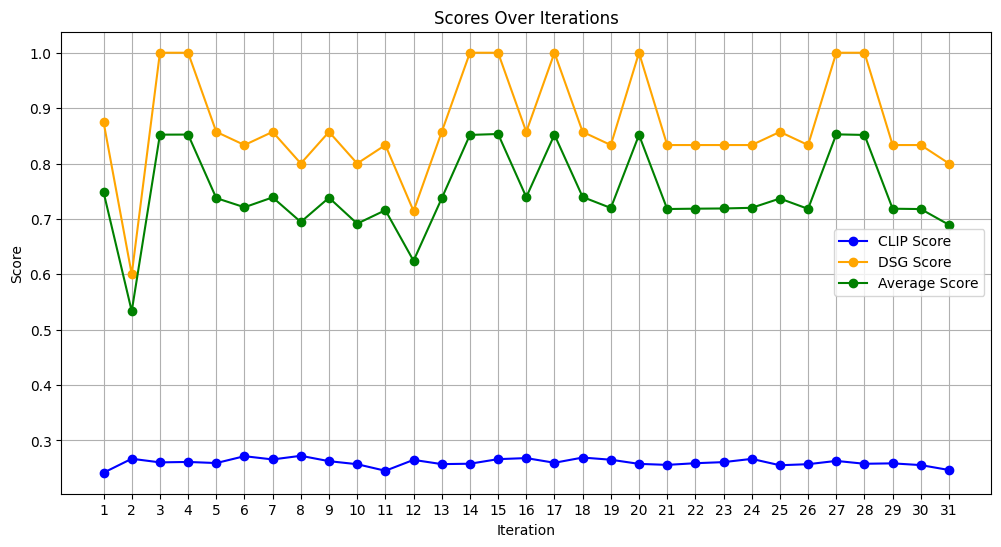

In [113]:
plot_scores(df_1)

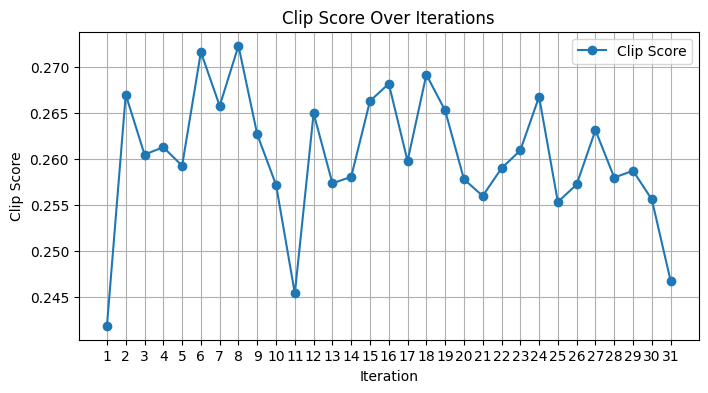

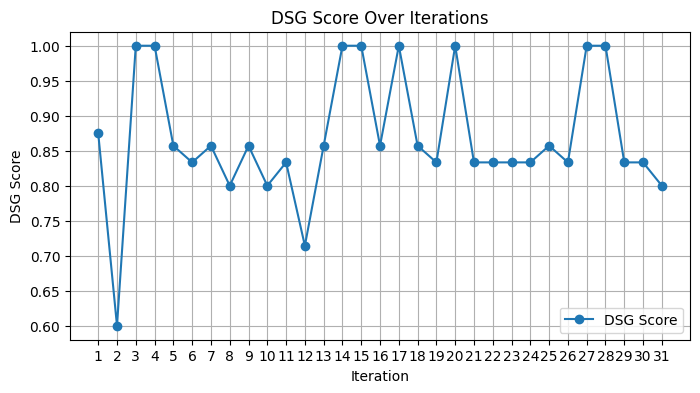

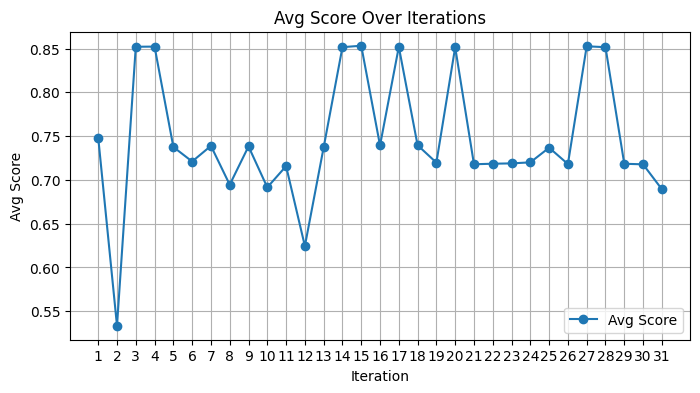

In [115]:
plot_individual_scores(df_1)

In [192]:
org = "A young girl in a red cloak walks through a forest, encountering a large, hungry wolf"
best_prompt = df_1.loc[df_1['Avg Score'].idxmax()]
best_avg = best_prompt['Avg Score']
best_dsg = best_prompt['DSG Score']
best_clip = best_prompt['Clip Score']

In [193]:
print(f"Best average score: {best_avg}")
print(f"Best DSG score: {best_dsg}")
print(f"Best CLIP score: {best_clip}")
print(f"Best prompt: {best_prompt['Prompt']}")

Best average score: 0.8532652519643307
Best DSG score: 1.0
Best CLIP score: 0.2663262598216533
Best prompt: Young girl in a red cloak walking through forest with nearby wolf.


In [137]:

df_1["Avg Score"].nunique()

31

In [136]:
# generate an image
image = pipe(org).images[0]
# save the image
image.save("generated_image_org.png")
clipOrg = compute_decomposed_clip_score("generated_image_org.png", org)
dsgOrg = DSG_Scorer("generated_image_org.png", org)
avgOrg = ((0.2 * clipOrg) + (0.8 * dsgOrg))

100%|██████████| 50/50 [00:16<00:00,  3.06it/s]
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she wearing a red cloak?
→ Answer: yes
→ Score: 1

Q3: Is she walking through a forest?
→ Answer: yes
→ Score: 1

Q4: Is there a wolf in the forest?
→ Answer: yes
→ Score: 1

Q5: Is the wolf large?
→ Answer: yes
→ Score: 1

Q6: Is the wolf hungry?
→ Answer: no
→ Score: 0

Average Score: 0.83


In [138]:
diffClip = best_clip - clipOrg
diffDSG = best_dsg - dsgOrg
diffAvg = best_avg - avgOrg 
print(f"Difference in CLIP Score: {diffClip:.4f}")
print(f"Difference in DSG Score: {diffDSG:.4f}")
print(f"Difference in Average Score: {diffAvg:.4f}")

Difference in CLIP Score: -0.0002
Difference in DSG Score: 0.1667
Difference in Average Score: 0.1333


# Second Prompt

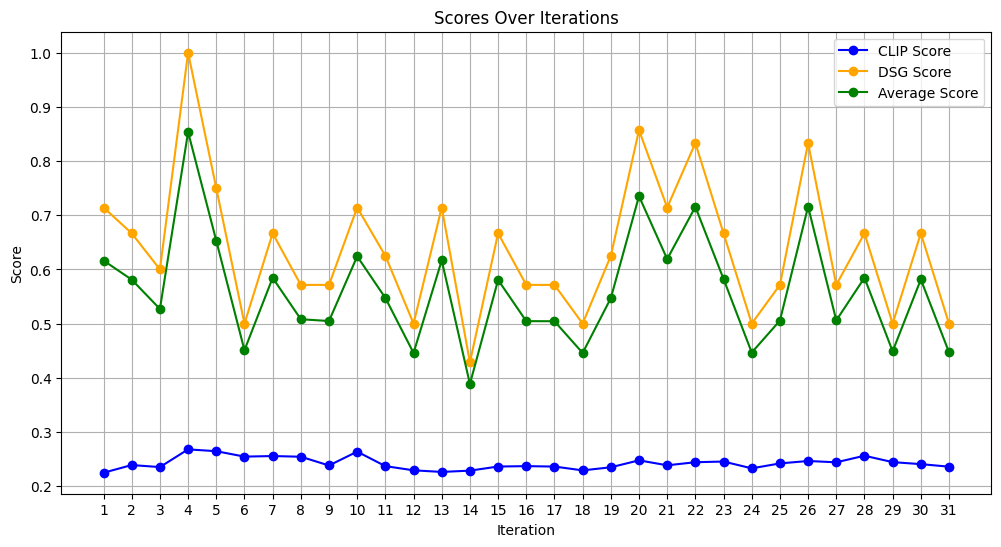

In [116]:
plot_scores(df_2)

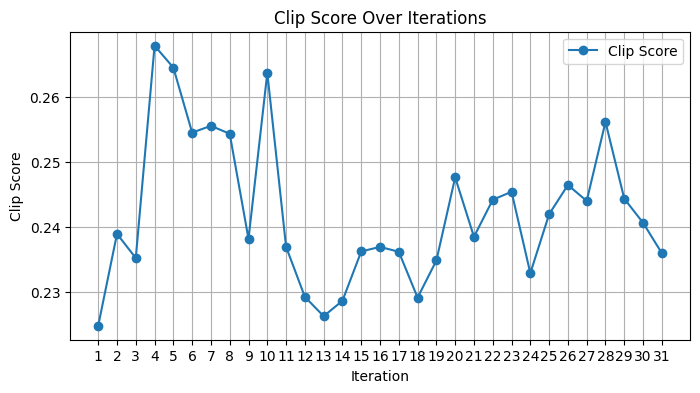

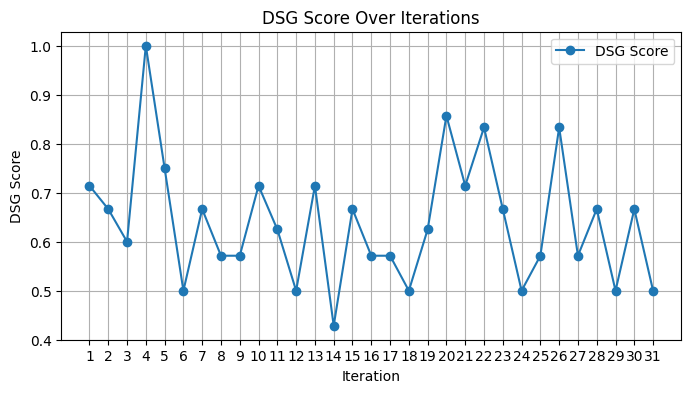

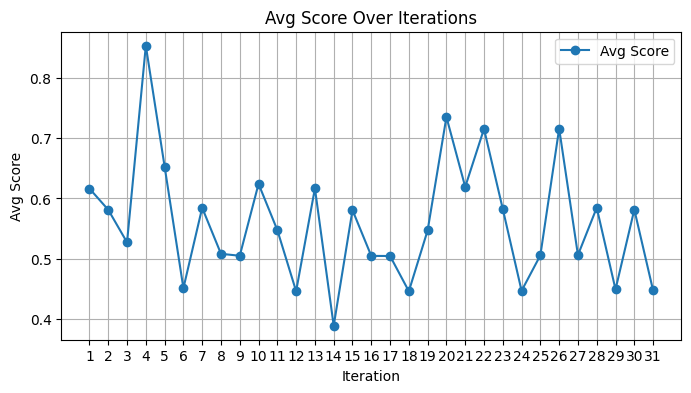

In [117]:
plot_individual_scores(df_2)

In [190]:
org = "A grandmothers' cozy cottage is invaded by a large, savage wolf that devours her"
best_prompt = df_2.loc[df_2['Avg Score'].idxmax()]
best_avg = best_prompt['Avg Score']
best_dsg = best_prompt['DSG Score']
best_clip = best_prompt['Clip Score']


In [191]:
print(f"Best average score: {best_avg}")
print(f"Best DSG score: {best_dsg}")
print(f"Best CLIP score: {best_clip}")
print(f"Best prompt: {best_prompt['Prompt']}")

Best average score: 0.853567898273468
Best DSG score: 1.0
Best CLIP score: 0.2678394913673401
Best prompt: "A grandmother's cozy cottage is overrun by a large savage wolf in a dark and eerie setting."


In [141]:

df_2["Avg Score"].nunique()

31

In [142]:
# generate an image
image = pipe(org).images[0]
# save the image
image.save("generated_image_org.png")
clipOrg = compute_decomposed_clip_score("generated_image_org.png", org)
dsgOrg = DSG_Scorer("generated_image_org.png", org)
avgOrg = ((0.2 * clipOrg) + (0.8 * dsgOrg))

100%|██████████| 50/50 [03:57<00:00,  4.76s/it]
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a grandmother?
→ Answer: no
→ Score: 0

Q2: Is the cottage cozy?
→ Answer: yes
→ Score: 1

Q3: Is the wolf large?
→ Answer: yes
→ Score: 1

Q4: Is the wolf savage?
→ Answer: no
→ Score: 0

Q5: Does the wolf devour the grandmother?
→ Answer: no
→ Score: 0

Average Score: 0.40


In [ ]:
print(f"Original CLIP score: {clipOrg:.4f}")
print(f"Original DSG score: {dsgOrg:.4f}")
print(f"Original avg score: {avgOrg:.4f}")


Original CLIP score: 0.2318
Original DSG score: 0.4000
Original avg score: 0.3664


In [143]:
diffClip = best_clip - clipOrg
diffDSG = best_dsg - dsgOrg
diffAvg = best_avg - avgOrg 
print(f"Difference in CLIP Score: {diffClip:.4f}")
print(f"Difference in DSG Score: {diffDSG:.4f}")
print(f"Difference in Average Score: {diffAvg:.4f}")

Difference in CLIP Score: 0.0360
Difference in DSG Score: 0.6000
Difference in Average Score: 0.4872


# Third Prompt

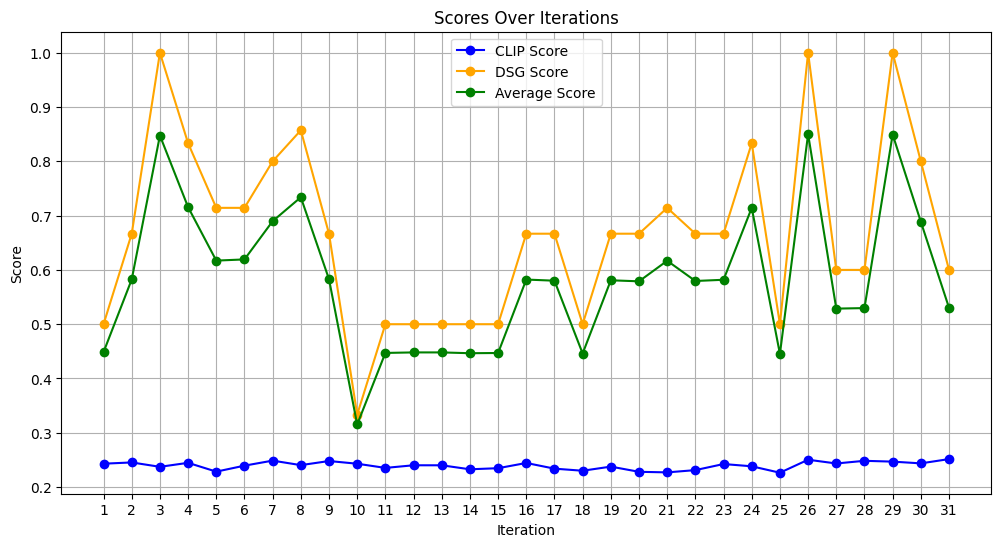

In [118]:
plot_scores(df_3)

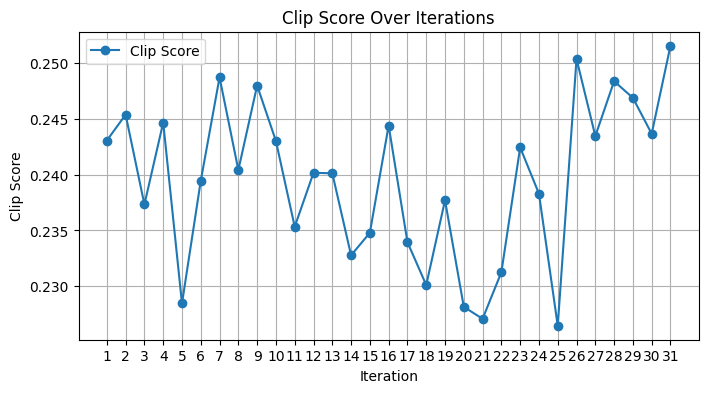

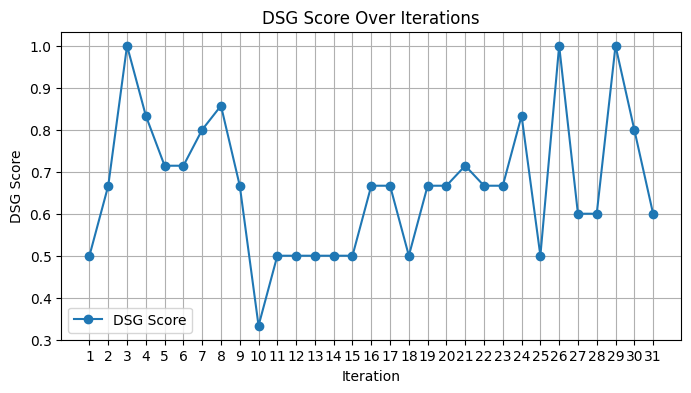

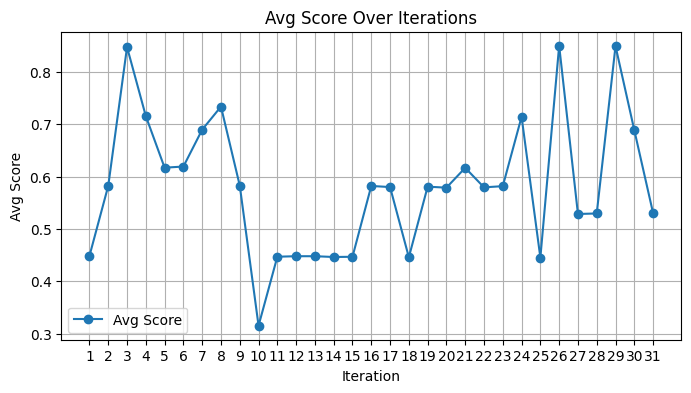

In [120]:
plot_individual_scores(df_3)

In [188]:
org = "A seasoned hunter enters a cottage to find a large wolf snoring loudly, suspecting it has consumed an elderly woman"
best_prompt = df_3.loc[df_3['Avg Score'].idxmax()]
best_avg = best_prompt['Avg Score']
best_dsg = best_prompt['DSG Score']
best_clip = best_prompt['Clip Score']

In [189]:
print(f"Best average score: {best_avg}")
print(f"Best DSG score: {best_dsg}")
print(f"Best CLIP score: {best_clip}")
print(f"Best prompt: {best_prompt['Prompt']}")

Best average score: 0.8500778734683991
Best DSG score: 1.0
Best CLIP score: 0.2503893673419952
Best prompt: "A seasoned hunter finds an elderly woman's lifeless body next to a sleeping wolf in a dimly lit cottage."


In [148]:
df_3["Avg Score"].nunique()

31

In [149]:
# generate an image
image = pipe(org).images[0]
# save the image
image.save("generated_image_org.png")
clipOrg = compute_decomposed_clip_score("generated_image_org.png", org)
dsgOrg = DSG_Scorer("generated_image_org.png", org)
avgOrg = ((0.2 * clipOrg) + (0.8 * dsgOrg))

100%|██████████| 50/50 [05:21<00:00,  6.44s/it]
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Is the wolf snoring loudly?
→ Answer: yes
→ Score: 1

Q3: Has the wolf consumed an elderly woman?
→ Answer: no
→ Score: 0

Q4: Is the cottage empty?
→ Answer: no
→ Score: 0

Q5: Is the wolf large?
→ Answer: yes
→ Score: 1

Average Score: 0.60


In [150]:
print(f"Original CLIP score: {clipOrg:.4f}")
print(f"Original DSG score: {dsgOrg:.4f}")
print(f"Original avg score: {avgOrg:.4f}")


Original CLIP score: 0.2262
Original DSG score: 0.6000
Original avg score: 0.5252


In [151]:
diffClip = best_clip - clipOrg
diffDSG = best_dsg - dsgOrg
diffAvg = best_avg - avgOrg 
print(f"Difference in CLIP Score: {diffClip:.4f}")
print(f"Difference in DSG Score: {diffDSG:.4f}")
print(f"Difference in Average Score: {diffAvg:.4f}")

Difference in CLIP Score: 0.0241
Difference in DSG Score: 0.4000
Difference in Average Score: 0.3248


# Fourth Prompt

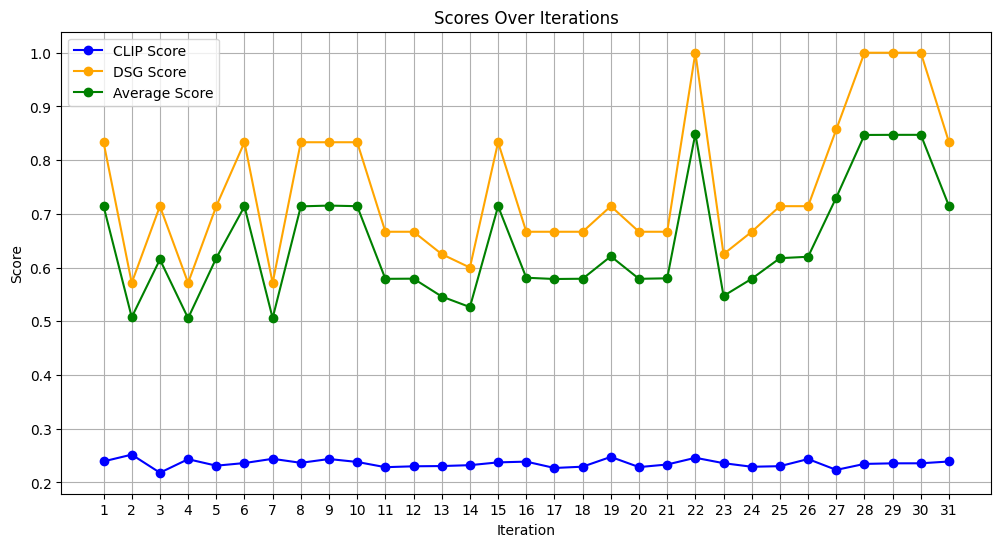

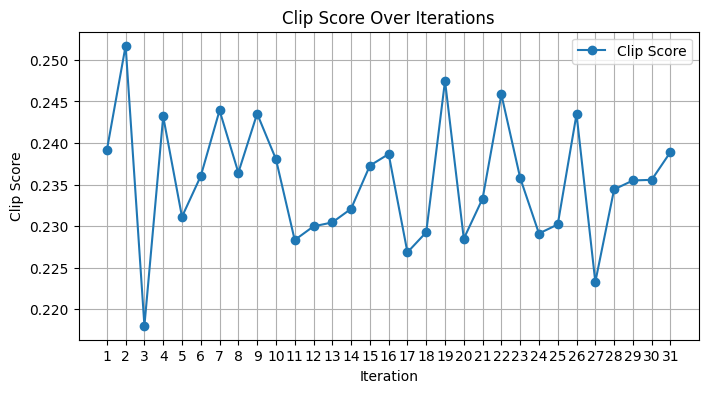

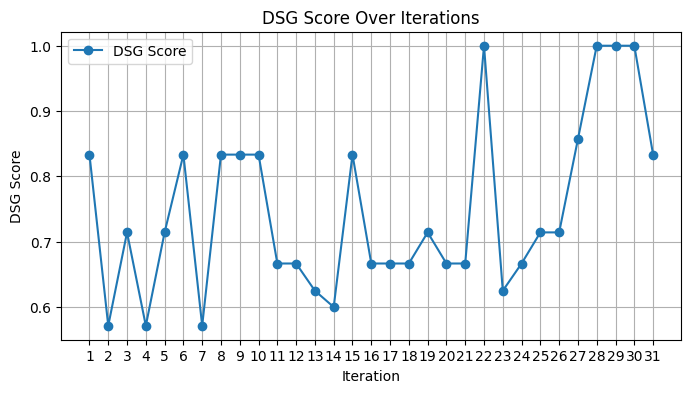

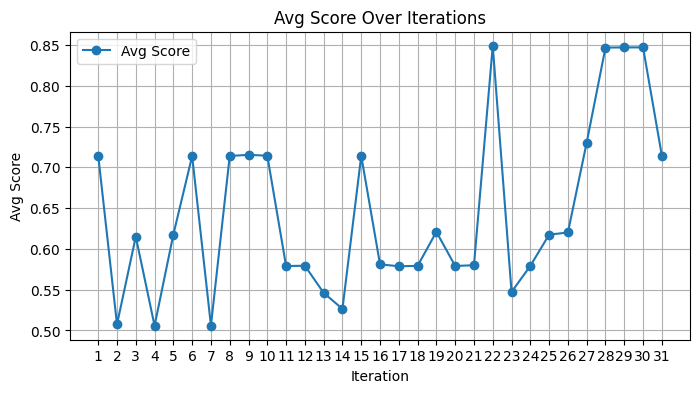

In [124]:
plot_scores(df_4)
plot_individual_scores(df_4)

In [186]:
org = "A brave hunter uses sharp blades to pierce through a beast's belly, freeing a frightened young girl trapped inside"
best_prompt = df_4.loc[df_4['Avg Score'].idxmax()]
best_avg = best_prompt['Avg Score']
best_dsg = best_prompt['DSG Score']
best_clip = best_prompt['Clip Score']

In [187]:
print(f"Best average score: {best_avg}")
print(f"Best DSG score: {best_dsg}")
print(f"Best CLIP score: {best_clip}")
print(f"Best prompt: {best_prompt['Prompt']}")

Best average score: 0.8491697589556376
Best DSG score: 1.0
Best CLIP score: 0.245848794778188
Best prompt: "A brave hunter cuts open a beast's belly to rescue a trapped young girl."


In [154]:

df_4["Avg Score"].nunique()

31

In [155]:
# generate an image
image = pipe(org).images[0]
# save the image
image.save("generated_image_org.png")
clipOrg = compute_decomposed_clip_score("generated_image_org.png", org)
dsgOrg = DSG_Scorer("generated_image_org.png", org)
avgOrg = ((0.2 * clipOrg) + (0.8 * dsgOrg))

100%|██████████| 50/50 [05:47<00:00,  6.95s/it]
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: no
→ Score: 0

Q2: Are the blades sharp?
→ Answer: yes
→ Score: 1

Q3: Is the beast pierced?
→ Answer: no
→ Score: 0

Q4: Is the girl trapped?
→ Answer: yes
→ Score: 1

Q5: Is the girl frightened?
→ Answer: yes
→ Score: 1

Q6: Is the girl young?
→ Answer: yes
→ Score: 1

Average Score: 0.67


In [156]:
print(f"Original CLIP score: {clipOrg:.4f}")
print(f"Original DSG score: {dsgOrg:.4f}")
print(f"Original avg score: {avgOrg:.4f}")


Original CLIP score: 0.2453
Original DSG score: 0.6667
Original avg score: 0.5824


In [157]:
diffClip = best_clip - clipOrg
diffDSG = best_dsg - dsgOrg
diffAvg = best_avg - avgOrg 
print(f"Difference in CLIP Score: {diffClip:.4f}")
print(f"Difference in DSG Score: {diffDSG:.4f}")
print(f"Difference in Average Score: {diffAvg:.4f}")

Difference in CLIP Score: 0.0006
Difference in DSG Score: 0.3333
Difference in Average Score: 0.2668


# Fifth Prompt

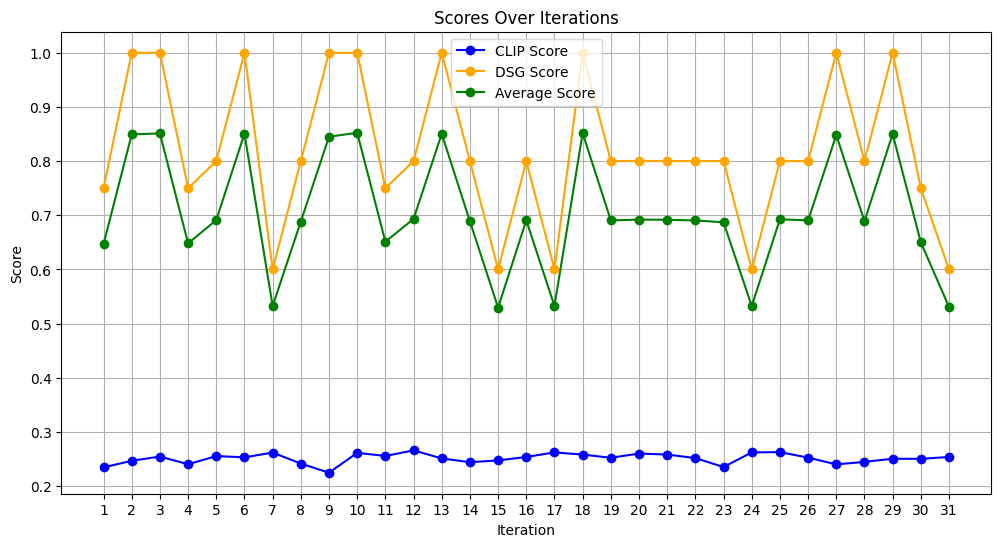

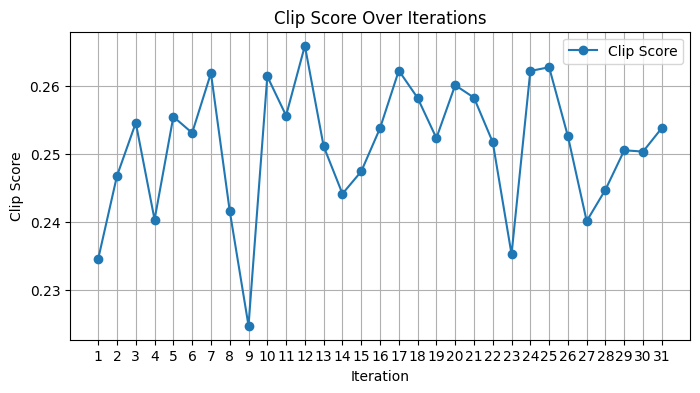

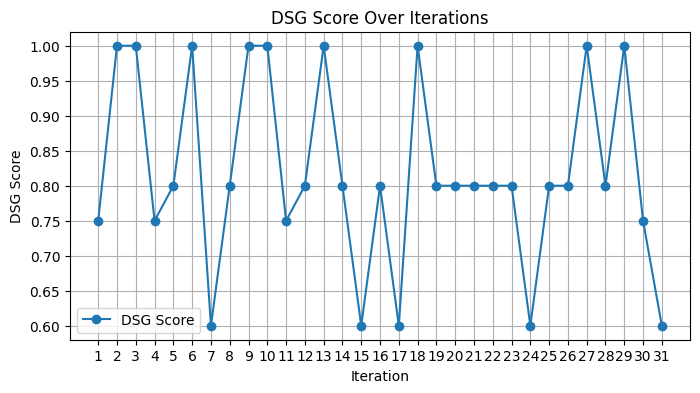

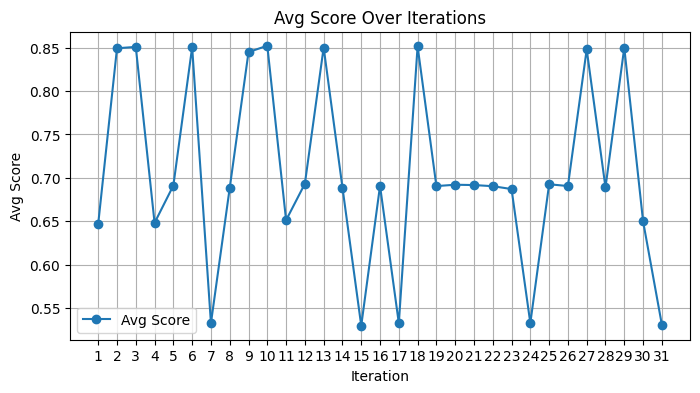

In [122]:
plot_scores(df_5)
plot_individual_scores(df_5)

In [177]:

df_5["Avg Score"].nunique()

31

In [178]:
# generate an image
image = pipe(org).images[0]
# save the image
image.save("generated_image_org.png")
clipOrg = compute_decomposed_clip_score("generated_image_org.png", org)
dsgOrg = DSG_Scorer("generated_image_org.png", org)
avgOrg = ((0.2 * clipOrg) + (0.8 * dsgOrg))

100%|██████████| 50/50 [07:37<00:00,  9.16s/it]
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a hunter?
→ Answer: yes
→ Score: 1

Q2: Is the hunter brave?
→ Answer: yes
→ Score: 1

Q3: Is there a wolf?
→ Answer: yes
→ Score: 1

Q4: Is the wolf dead?
→ Answer: no
→ Score: 0

Q5: Are the rocks massive?
→ Answer: no
→ Score: 0

Q6: Is the wolf's belly being loaded with rocks?
→ Answer: yes
→ Score: 1

Average Score: 0.67


In [184]:
print(f"Original CLIP score: {clipOrg:.4f}")
print(f"Original DSG score: {dsgOrg:.4f}")
print(f"Original avg score: {avgOrg:.4f}")
print(f"Original prompt: {org}")

Original CLIP score: 0.2323
Original DSG score: 0.6667
Original avg score: 0.5798
Original prompt: A brave hunter loads a giant wolf's belly with massive rocks, crushing its lifeless body


In [175]:
print(f"Best average score: {best_avg}")
print(f"Best DSG score: {best_dsg}")
print(f"Best CLIP score: {best_clip}")
print(f"Best prompt: {best_prompt['Prompt']}")

Best average score: 0.8522904147704443
Best DSG score: 1.0
Best CLIP score: 0.2614520738522212
Best prompt: "A hunter loads massive rocks onto a crushed giant wolf."


In [185]:
diffClip = best_clip - clipOrg
diffDSG = best_dsg - dsgOrg
diffAvg = best_avg - avgOrg 
print(f"Difference in CLIP Score: {diffClip:.4f}")
print(f"Difference in DSG Score: {diffDSG:.4f}")
print(f"Difference in Average Score: {diffAvg:.4f}")

Difference in CLIP Score: 0.0292
Difference in DSG Score: 0.3333
Difference in Average Score: 0.2725


# Sixth Prompt

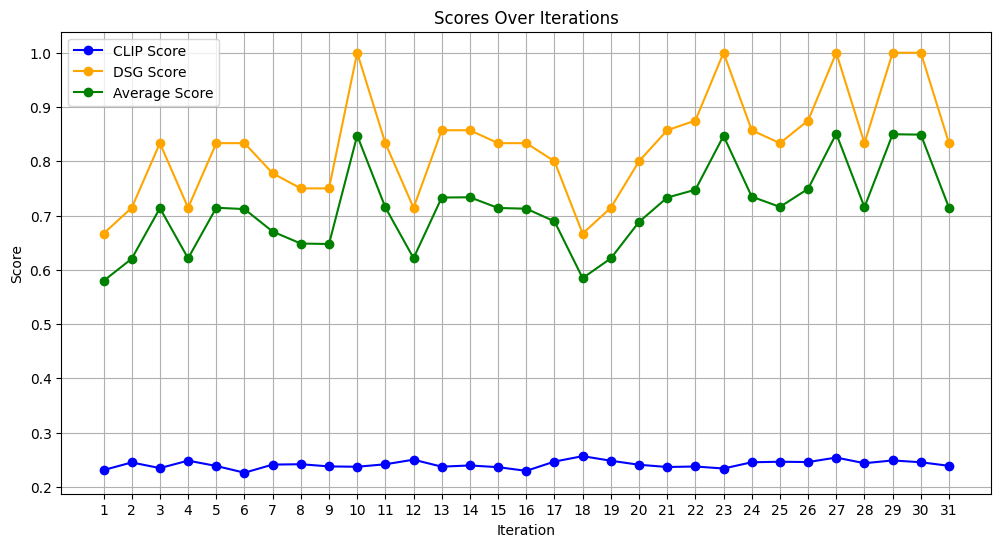

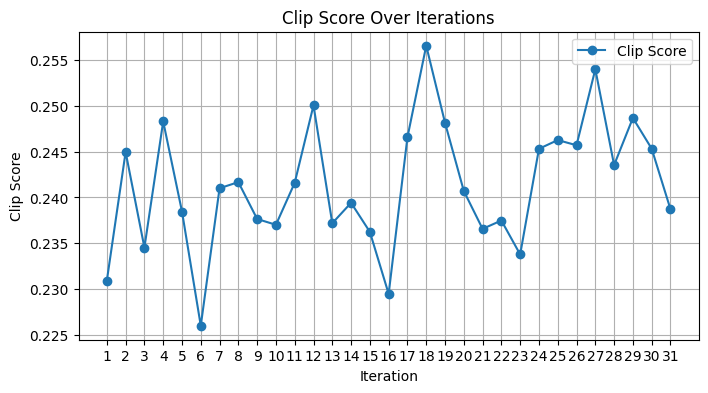

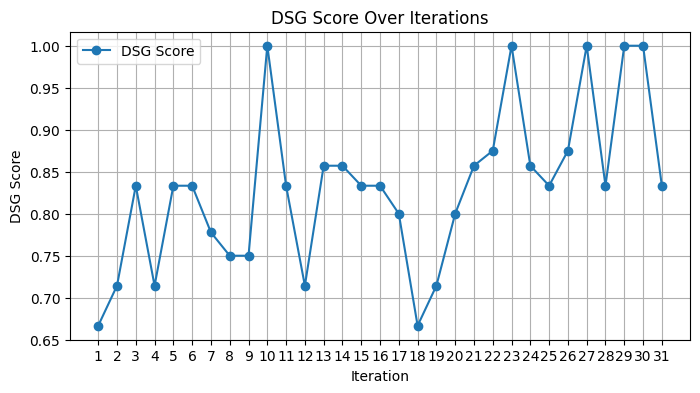

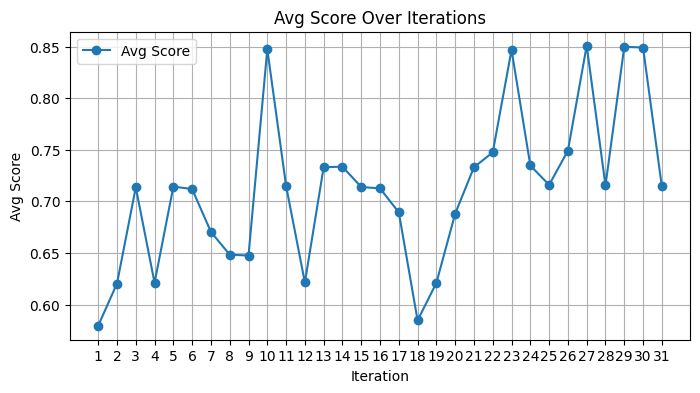

In [123]:
plot_scores(df_6)
plot_individual_scores(df_6)

In [165]:
org = "A young girl brings relief to her grandmother, reviving her with a rejuvenating meal while a brave hunter shares in their joy"
best_prompt = df_6.loc[df_6['Avg Score'].idxmax()]
best_avg = best_prompt['Avg Score']
best_dsg = best_prompt['DSG Score']
best_clip = best_prompt['Clip Score']

In [166]:

df_6["Avg Score"].nunique()

31

In [167]:
# generate an image
image = pipe(org).images[0]
# save the image
image.save("generated_image_org.png")
clipOrg = compute_decomposed_clip_score("generated_image_org.png", org)
dsgOrg = DSG_Scorer("generated_image_org.png", org)
avgOrg = ((0.2 * clipOrg) + (0.8 * dsgOrg))

100%|██████████| 50/50 [04:50<00:00,  5.82s/it]
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\huggingface_hub\file_download.py:943: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
c:\Users\zeina\Desktop\Event Extraction\Llama8B\lib\site-packages\transformers\generation\utils.py:1132: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Independent Question Evaluation (BLIP):
Q1: Is there a young girl?
→ Answer: yes
→ Score: 1

Q2: Is she bringing relief to someone?
→ Answer: yes
→ Score: 1

Q3: Is it her grandmother who is being revived?
→ Answer: no
→ Score: 0

Q4: Does the revival involve food?
→ Answer: yes
→ Score: 1

Q5: Is the meal rejuvenating?
→ Answer: yes
→ Score: 1

Q6: Are they sharing their joy with someone else?
→ Answer: yes
→ Score: 1

Q7: Is that person a hunter?
→ Answer: no
→ Score: 0

Average Score: 0.71


In [171]:
print(f"Original CLIP score: {clipOrg:.4f}")
print(f"Original DSG score: {dsgOrg:.4f}")
print(f"Original avg score: {avgOrg:.4f}")
print(f"Original prompt: {org}")

Original CLIP score: 0.2325
Original DSG score: 0.7143
Original avg score: 0.6179
Original prompt: A young girl brings relief to her grandmother, reviving her with a rejuvenating meal while a brave hunter shares in their joy


In [172]:
print(f"Best average score: {best_avg}")
print(f"Best DSG score: {best_dsg}")
print(f"Best CLIP score: {best_clip}")
print(f"Best prompt: {best_prompt['Prompt']}")

Best average score: 0.8507961682975292
Best DSG score: 1.0
Best CLIP score: 0.2539808414876461
Best prompt: "A young girl cares for her elderly grandmother as a brave hunter joins in their joyful reunion."


In [170]:
diffClip = best_clip - clipOrg
diffDSG = best_dsg - dsgOrg
diffAvg = best_avg - avgOrg 
print(f"Difference in CLIP Score: {diffClip:.4f}")
print(f"Difference in DSG Score: {diffDSG:.4f}")
print(f"Difference in Average Score: {diffAvg:.4f}")

Difference in CLIP Score: 0.0215
Difference in DSG Score: 0.2857
Difference in Average Score: 0.2329


In [31]:
c=df_log3["Prompt"].count()
for i in range(c):
    print(f"Iteration {df_log3['Iteration'][i]}: {df_log3['Prompt'][i]} ")

Iteration 1: A young girl, dressed in worn rural clothing, stands at the edge of a misty forest, looking up at her concerned-looking mother who is holding a basket and gesturing towards the trees with a mix of warning and caution on her face. 
Iteration 2: "A young girl in worn rural attire stands at forest's edge, gazing up at her mother who cautions from behind a basket, conveying concern amidst misty surroundings." 
Iteration 3: "A young girl with worn, rustic clothing stands beside her mother on the forest's edge, gazing up at her mother's cautious expression, subtly warning of potential dangers while holding a basket amidst soft morning mist." 
Iteration 3: "A young girl with worn, rustic clothing stands beside her mother on the forest's edge, gazing up at her mother's cautious expression, subtly warning of potential dangers while holding a basket amidst soft morning mist." 
Iteration 1: A young girl with an innocent expression treks through a mist-shrouded forest, her attention d

# Additional Functions

In [11]:
def check_memory_usage():
    import torch
    print(f"Allocated VRAM: {torch.cuda.memory_allocated() / 1e9:.2f} GB")
    print(f"Reserved VRAM:  {torch.cuda.memory_reserved() / 1e9:.2f} GB")


In [12]:
def clear_gpu_cache():
    import torch
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()


In [13]:
def clear_cpu_cache():
    import torch
    import gc
# Delete all PyTorch objects
    gc.collect()
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()